In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

In [3]:
curr_path = os.getcwd().split("/")
curr_path = curr_path[: len(curr_path) - 1]
curr_path.append("src")
curr_path = "/".join(curr_path)
if curr_path not in sys.path:
    sys.path.append(curr_path)

In [4]:
import gc
import pickle
from time import time

import numpy as np
import torch
import torch.nn as nn
from explainer import *
from helpers import BaseRunner
from models.sequential.GRU4Rec import GRU4Rec
from torch.utils.data import DataLoader
from tqdm import tqdm
from utils import utils

In [5]:
# loading arguments from args.pkl(run argcorpus.py with model inputs from Command line i.e. python argscorpus.py --dataset ml-1m --model_name GRU4Rec)
with open("../data/ml-1m/args.pkl", "rb") as f:
    args = pickle.load(f)

with open("../data/ml-1m/SeqReader.pkl", "rb") as f:
    corpus = pickle.load(f)
    model = GRU4Rec(args, corpus)

In [6]:
# loading file path
file_path = (
    "../model/GRU4Rec/GRU4Rec__ml-1m__0__lr=0.001__l2=0__emb_size=64__hidden_size=64.pt"
)

model.load_state_dict(torch.load(file_path))

<All keys matched successfully>

In [7]:
class GRU4RecExp(GRU4Rec):
    def predict_interaction(self, feed_dict, topk=10):
        pred = self.forward(feed_dict)["prediction"]
        sort_idx = (-pred).argsort(axis=1)
        return sort_idx[0][:topk]

In [8]:
model_check = GRU4RecExp(args, corpus)
model_check.load_state_dict(torch.load(file_path))

<All keys matched successfully>

In [9]:
model_check

GRU4RecExp(
  (i_embeddings): Embedding(3707, 64)
  (rnn): GRU(64, 64, batch_first=True)
  (out): Linear(in_features=64, out_features=64, bias=True)
)

In [10]:
# list of all items present
item_id = [list(range(1, model_check.item_num))]

# interaction history of items
history_items = [
    [
        907,
        2915,
        335,
        1248,
        514,
        853,
        3204,
        312,
        1157,
        1161,
        1486,
        2522,
        528,
        2006,
        1169,
        1176,
        1193,
        3108,
        882,
        1092,
    ]
]
# user id
user_id = [6034]
# lengths
lengths = [len(x) for x in history_items]

batch_size = len(user_id)

In [11]:
sample = {
    "user_id": torch.tensor(user_id),
    "item_id": torch.tensor(item_id),
    "history_items": torch.tensor(history_items),
    "lengths": torch.tensor(lengths),
    "batch_size": batch_size,
}

In [12]:
predictions = model_check.predict_interaction(sample)

In [13]:
predictions

tensor([ 158, 3107, 1091,  881,  852, 1192, 1617, 1885, 1156, 2021])

## Leave-one-out analysis

In [14]:
# Generate counterfactual sequences
counterfactuals = generate_counterfactuals(history_items[0])

In [15]:
# Evaluate counterfactual sequences
cf_differences = evaluate_counterfactuals(
    model_check, user_id, item_id, batch_size, counterfactuals, predictions
)

In [16]:
cf_differences

array([0.93374578, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.93637921, 0.93056878,
       0.93637921, 1.        , 1.        , 0.82369989, 0.61179524])

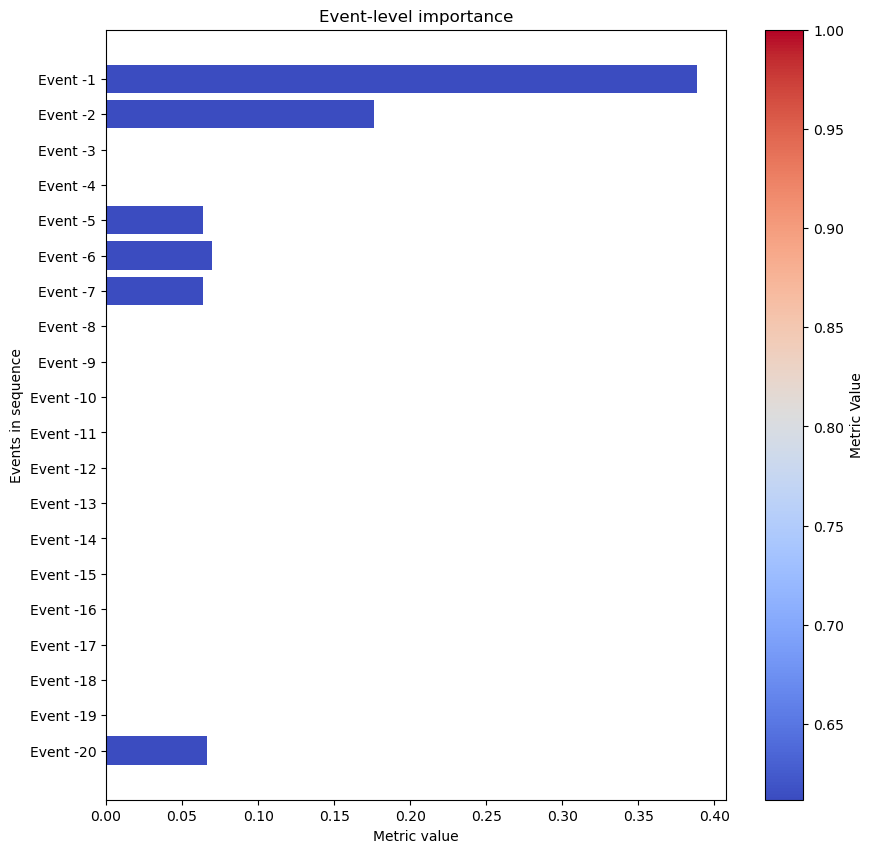

In [17]:
plot_metric_values(cf_differences, sample["history_items"].cpu().numpy()[0])

# Perturbations

In [18]:
# Initialize the SeqExplainer
explainer = SeqExplainer(model_check, item_id[0], corpus)

In [19]:
# Generate NDCG values
ndcg_values = explainer.explain(sample, num_samples=10)

In [20]:
# Print NDCG values
print("NDCG values:", ndcg_values)

NDCG values: [0.93374578 1.         1.         1.         1.         1.
 0.93637921 0.93637921 0.93056878 0.93056878 1.         1.
 0.93374578 0.93374578 0.93637921 0.86301529 0.85798094 0.72891153
 0.06362079 0.17630011]


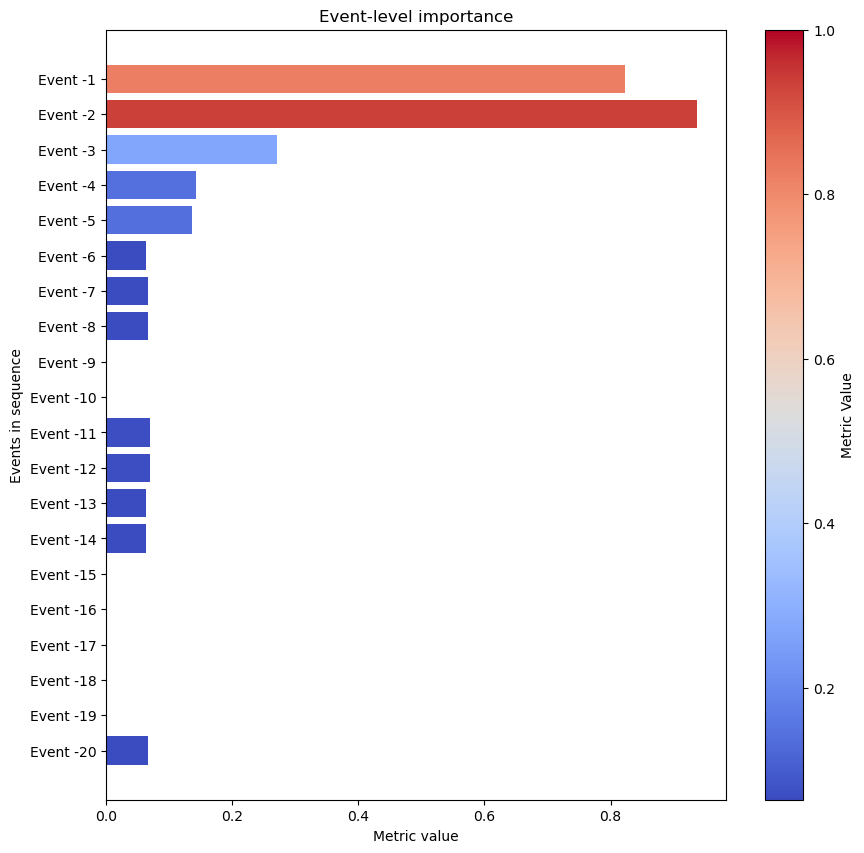

In [21]:
plot_metric_values(ndcg_values, sample["history_items"].cpu().numpy()[0])